目前基于Python的量化回测框架有很多，离线开源的有zipline、vnpy、pyalgotrader和backtrader等，而量化平台有Quantopian（国外）、聚宽、万矿、优矿、米筐、掘金等等，这些量化框架和平台各有优缺点，没有所谓的好坏之分。从个人经验而言，比较偏好用backtrader，因为它功能十分完善，有完整的使用文档，安装相对简单（直接pip安装即可）；运行速度快，支持pandas的矢量运算；支持参数自动寻优运算，内置了talib股票分析技术指标库；支持多品种、多策略、多周期的回测和交易；支持pyflio、empyrica分析模块库、alphalens多因子分析模块库等；扩展灵活，可以集成TensorFlow、PyTorch和Keras等机器学习、神经网络分析模块。当然，backtrader的不足在于学习起来相对复杂，编程过程中使用了大量的类（class），如果Python编程基础不扎实（尤其是类的操作），学起来会比较吃力。

将backtrader软件包分解为核心组件，并介绍创建自己交易系统的基本知识。  
1、数据加载。交易策略的数据需要加载到回测框架中。  
2、交易策略。交易策略是编程过程中最复杂的部分，因为这是决策买入/卖出标的部分。  
3、回测框架设置。 Cerebro是回测器的名称。 Cerebro需要几个设置，例如（i）交易资本（ii）经纪佣金（iii）数据馈送（iv）交易策略（v）每个交易头寸的大小。  
4、运行回测。运行Cerebro回测器并打印出所有已执行的交易。  
5、评估性能。以图形方式评估回测交易策略的性能。

“Lines”是backtrader回测的数据输入，由一系列的点组成，通常包括以下类别的数据：Open（开盘价）, High（最高价）, Low（最低价）, Close（收盘价）, Volume（成交量）, OpenInterest。Data Feeds（数据加载）、Indicators（技术指标）和Strategies（策略）都是 Lines。价格数据中的所有”Open” (开盘价)按时间组成一条 Line。所以，一组含有以上6个类别的价格数据，共有6条 Lines。如果算上“DateTime”（时间，可以看作是一组数据的主键），一共有7条 Lines。当访问一条 Line 的数据时，会默认指向下标为 0 的数据。最后一个数据通过下标 -1 来访问，在-1之后是索引0，用于访问当前时刻。因此，在回测过程中，无需知道已经处理了多少条/分钟/天/月，”0”一直指向当前值，下标 -1 来访问最后一个值。

# 加载数据

In [1]:
#先引入后面可能用到的包（package）
import pandas as pd  
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [2]:
#使用tushare旧版接口获取数据
import tushare as ts 
def get_data(code,start='2010-01-01',end='2020-03-31'):
    df=ts.get_k_data(code,autype='qfq',start=start,end=end)
    df.index=pd.to_datetime(df.date)
    df['openinterest']=0
    df=df[['open','high','low','close','volume','openinterest']]
    return df

In [3]:
dataframe=get_data('600000')
dataframe.tail()

,open,high,low,close,volume,openinterest
date,,,,,,
2020-03-24,10.03,10.13,9.98,10.06,289908.0,0
2020-03-25,10.20,10.27,10.12,10.15,321723.0,0
2020-03-26,10.10,10.37,10.08,10.23,309218.0,0
2020-03-27,10.35,10.38,10.20,10.24,271080.0,0
2020-03-30,10.18,10.28,10.11,10.28,260460.0,0


# 构建策略

交易策略类代码包含重要的参数和用于执行策略的功能。策略类的重要方面如下：

params-更改交易策略中任何变量/参数的值，而不用深入代码本身。 log：日志-这是您策略的日志记录功能。它将打印出该函数提供的日期时间和txt变量。 init-用于初始化交易策略的类实例的代码。 notify_order-跟踪任何订单的状态。订单具有提交，接受，购买/出售执行和价格，已取消/拒绝等状态。 notify_trade-跟踪任何交易的状态。任何已平仓的交易都将报告毛利和净利润。 next下一个-这是实际制定交易策略的地方。下一个命令是指当我们进入下一个交易栏/窗口时，它执行检查以查看a。订单待处理吗？

In [4]:
class my_strategy1(bt.Strategy):
    #全局设定交易策略的参数
    params=(
        ('maperiod',20),
           )
    
    def __init__(self):
        #指定价格序列
        self.dataclose=self.datas[0].close
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buyprice = None
        self.buycomm = None

        #添加移动均线指标
        self.sma = bt.indicators.SimpleMovingAverage(
                      self.datas[0], period=self.params.maperiod)
    def next(self):
        if self.order: # 检查是否有指令等待执行, 
            return
        # 检查是否持仓   
        if not self.position: # 没有持仓
            #执行买入条件判断：收盘价格上涨突破20日均线
            if self.dataclose[0] > self.sma[0]:
                #执行买入
                self.order = self.buy(size=500)         
        else:
            #执行卖出条件判断：收盘价格跌破20日均线
            if self.dataclose[0] < self.sma[0]:
                #执行卖出
                self.order = self.sell(size=500)

# 回测设置

回测器称为Cerebro，并且需要进行以下几种设置：

添加交易策略-必须将策略添加到回测器中，以便它可以开始测试系统的性能。 数据-数据需要添加到回测器，以便可以在其上实施交易策略。 经纪人设置-经纪人设置（例如，交易资本的金额和交易佣金）需要用来指示执行交易策略时积累的总财富和净财富。 头寸规模-设置作为策略一部分的交易规模。

In [5]:
# 初始化cerebro回测系统设置                           
cerebro = bt.Cerebro()  
#回测期间
start=datetime(2010, 3, 31)
end=datetime(2020, 3, 31)
# 加载数据
data = bt.feeds.PandasData(dataname=dataframe,fromdate=start,todate=end)
#将数据传入回测系统
cerebro.adddata(data) 
# 将交易策略加载到回测系统中
cerebro.addstrategy(my_strategy1) 
# 设置初始资本为10,000
startcash = 10000
cerebro.broker.setcash(startcash) 
# 设置交易手续费为 0.2%
cerebro.broker.setcommission(commission=0.002) 
#股票交易的手续费一般由交易佣金、印花税、过户费3部分组成，其中佣金不同证券公司的收费不同，一般在买卖金额的0.1%-0.3%之间，最低收费为5元

# 执行回测

In [7]:
d1=start.strftime('%Y%m%d')
d2=end.strftime('%Y%m%d')
print(f'初始资金: {startcash}\n回测期间：{d1}:{d2}')
#运行回测系统
cerebro.run()
#获取回测结束后的总资金
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash
#打印结果
print(f'总资金: {round(portvalue,2)}')
print(f'净收益: {round(pnl,2)}')

初始资金: 10000
回测期间：20100331:20200331
总资金: 12065.36
净收益: 2065.36


# 可视化

<IPython.core.display.Javascript object>


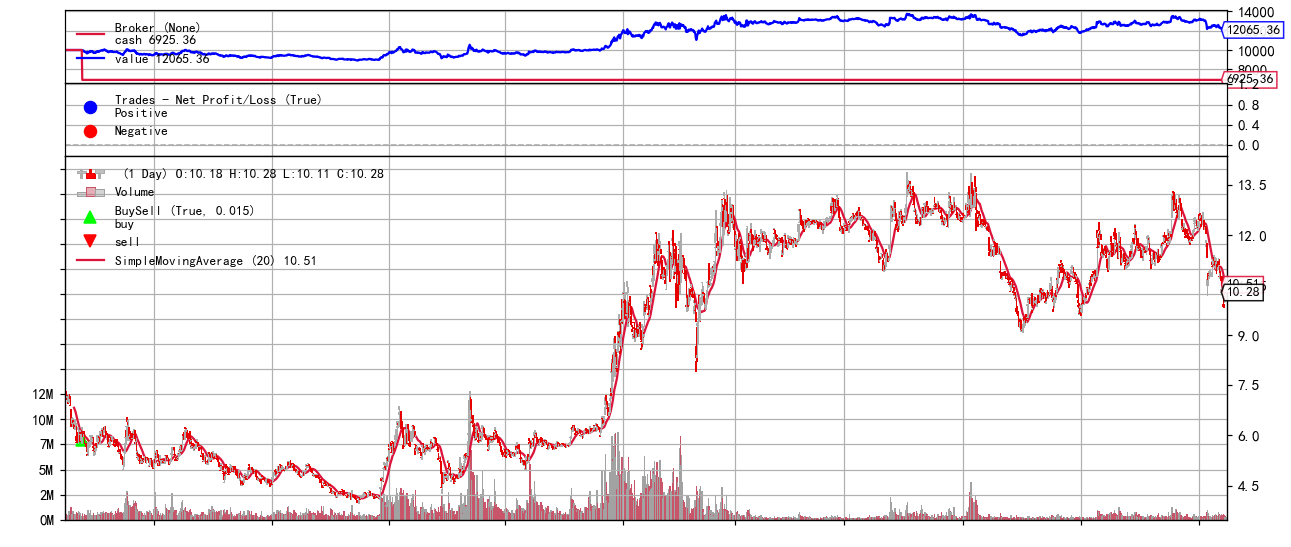

[[<Figure size 432x288 with 4 Axes>]]

In [8]:
%matplotlib inline 
cerebro.plot(style='candlestick')